In [1]:
from __future__ import division, print_function

import os, glob
import numpy as np
import matplotlib.pyplot as plt

from rvseg import patient

%matplotlib inline

## Visualize Images and Masks

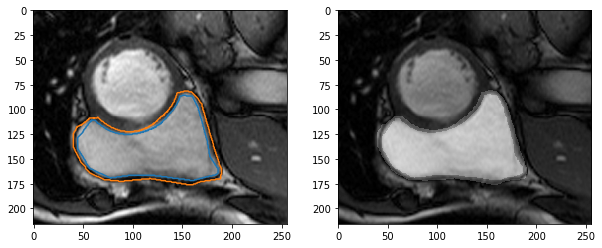

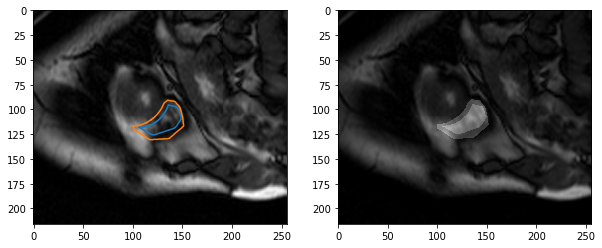

In [43]:
datadir = "/home/paperspace/Developer/datasets/RVSC/TrainingSet/patient09/"
p = patient.PatientData(datadir)

alpha = 0.2
for index in [0, -1]:
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(p.images[index], cmap=plt.cm.gray)
    plt.plot(*p.endocardium_contours[index])
    plt.plot(*p.epicardium_contours[index])
    plt.subplot(1, 2, 2)
    plt.imshow(p.images[index], cmap=plt.cm.gray)
    plt.imshow(p.endocardium_masks[index], cmap=plt.cm.gray, alpha=alpha)
    plt.imshow(p.epicardium_masks[index], cmap=plt.cm.gray, alpha=alpha)

## Construct histograms

Three-component histograms: background, cardiac muscle, right ventricle cavity.

Data is strongly biased towards background pixels, which will affect training.

In [5]:
from collections import Counter

glob_search = "/home/paperspace/Developer/datasets/RVSC/TrainingSet/patient*"
datadirs = glob.glob(glob_search)

counter_background = Counter()
counter_muscle = Counter()
counter_cavity = Counter()
for datadir in datadirs:
    p = patient.PatientData(datadir)
    for image, endo_mask, epi_mask in zip(p.images, p.endocardium_masks, p.epicardium_masks):
        endo_bmask = endo_mask // 255
        epi_bmask = epi_mask // 255
        background = image * (1 - epi_bmask)
        muscle = image * (epi_bmask - endo_bmask)
        cavity = image * endo_bmask
        counter_background += Counter(background.flatten())
        counter_muscle += Counter(muscle.flatten())
        counter_cavity += Counter(cavity.flatten())

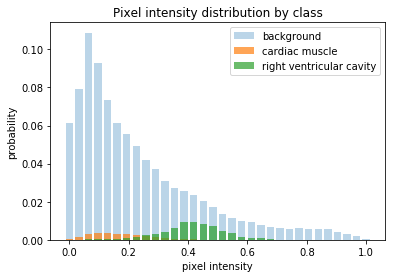

In [36]:
def rebin(counter, factor=8):
    assert 256 % factor == 0
    counts = np.array([counter[n] for n in range(256)])
    return np.sum(counts.reshape((len(counts)//factor, factor)), axis=1)

counter_background[0] = 0
counter_muscle[0] = 0
counter_cavity[0] = 0

alpha = 0.7
factor = 8
nbins = 256//factor
x = np.arange(nbins)/(nbins-1)
width = 0.8/nbins
norm = (sum(counter_background.values()) + sum(counter_muscle.values()) +
        sum(counter_cavity.values()))
plt.bar(x, rebin(counter_background, factor)/norm,
        width=width, alpha=0.3, label='background')
plt.bar(x, rebin(counter_muscle, factor)/norm,
        width=width, alpha=alpha, label='cardiac muscle')
plt.bar(x, rebin(counter_cavity, factor)/norm,
        width=width, alpha=alpha, label='right ventricular cavity')
plt.legend()
plt.xlabel("pixel intensity")
plt.ylabel("probability")
plt.title("Pixel intensity distribution by class")

## Generate Video

Create videos of beating heart of each patient. Grayscale frames are scaled by their maximum value.

In [44]:
glob_search = "/home/paperspace/Developer/datasets/RVSC/TrainingSet/patient*"
datadirs = sorted(glob.glob(glob_search))

FPS=24
for datadir in datadirs:
    p = patient.PatientData(datadir)
    index = os.path.basename(datadir)[-2:]
    outfile = "out{}.mp4".format(index)
    p.write_video(outfile=outfile, FPS=FPS)